In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class WilsonCowanParams:
    def __init__(self):
        self.r = 0.2 
        self.tau_E = 1.0
        self.tau_I = 2.0
        self.w_ee = 8 + np.random.randn()
        self.w_ei = 4 + np.random.randn()
        self.w_ie = 10 + np.random.randn()
        self.w_ii = 3 + np.random.randn()
        self.P = 1 + 0.1 * np.random.randn()
        self.Q = 1 + 0.1 * np.random.randn()

class Region:
    def __init__(self, region_id, T, dt):
        t = np.arange(0, T + dt, dt)
        self.region_id = region_id
        self.E = np.zeros(len(t))
        self.I = np.zeros(len(t))

        self.E[0] = 0.2
        self.I[0] = 0.3

        self.params = WilsonCowanParams()

        
def sig(x):
    return 1 / (1 + np.exp(-x))

def dedt(t, E, I, E_ext, region : Region, C):
    params = region.params
    print(np.dot(C[region.region_id], E_ext), params.w_ee*E)
    return (-E + (1 - params.r*E) * Se(params.w_ee*E + G * np.dot(C[region.region_id], E_ext) - params.w_ei*I + params.P)) / params.tau_E

def didt(t, E, I,region):
    params = region.params
    return (-I + (1 - params.r*I) * Si(params.w_ie*E - params.w_ii*I + params.Q)) / params.tau_I

def plot_results(regions, t):
    fig, axs = plt.subplots(10, 10, figsize=(60, 60))
    axs = axs.ravel()
    
    for i, region in enumerate(regions):  # Plot first 4 regions
        axs[i].plot(t, region.E, label='E')
        axs[i].plot(t, region.I, label='I')
        axs[i].set_title(f'Region {region.region_id}')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Activity')
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

# Main simulation
num_regions = 100
T = 100
dt = 0.01
G = 2.
  
# Load and normalise connectivity matrix
C = pd.read_csv('./fmri/DTI_fiber_consensus_HCP.csv', header=None).to_numpy()[:num_regions, :num_regions]
np.fill_diagonal(C, 0)
C /= C.sum(axis=1)[:, np.newaxis]

# Run simulation
t = np.arange(0, T + dt, dt)
regions = [Region(i, T, dt) for i in range(num_regions)]

for i in range(len(t) - 1):
    E_ext = np.array([r.E[i] for r in regions])
    
    for r in range(num_regions):
        curr = regions[r]
        
        curr.E[i + 1] = curr.E[i] + dt * (dedt(t[i], curr.E[i], curr.I[i], E_ext, curr, C))
        curr.I[i + 1] = curr.I[i] + dt * (didt(t[i], curr.E[i], curr.I[i], curr))

# Plot results
plot_results(regions, t)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('animation', html='jshtml')

%matplotlib inline

# constants
r = .2
tau_E = 1.
tau_I = 2.

P = 0.2
Q = .5

w_ee = 10
w_ei = 12
w_ie = 9
w_ii = 3

def sig(x):
    return 1/(1 + np.exp(-x))

def tanh(x):
    return 2*sig(2*x) - 1

def dedt(t, E, I, P):
    de = (-E + (1 - r*E)*sig(w_ee*E - w_ei*I + P)) / tau_E
    # de = (-E + sig(k*E + k*P)) / tau_E
    return de

def didt(t, E, I, Q):
    di = (-I + (1 - r*I)*sig(w_ie*E - w_ii*I + Q)) / tau_I
    return np.array([di])

T = 6
dt = .01
t = np.arange(0, T + dt, dt)
E = np.zeros(len(t))
I = np.zeros(len(t))

for i in range(len(t) - 1):
    E[i + 1] = E[i] + dt * dedt(t[i], E[i], I[i], P)
    I[i + 1] = I[i] + dt * didt(t[i], E[i], I[i], Q)

# E += np.random.normal(0, 0.01, E.shape)
plt.plot(E, label='Excitatory')
plt.plot(I, label='Inhibitory')
# plt.plot(I, label='Inhibitory')
plt.legend()

# np.save('E_synthetic_kdot5_Pdot2.npy', E)
plt.xlabel('Time')
plt.ylabel('Activity')
# plt.savefig('varying_k.pdf', dpi=600)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import norm

N    = 200
X    = np.linspace(-4, 4, N)
Y    = np.linspace(-4, 4, N)
X, Y = np.meshgrid(X, Y)
pos  = np.dstack((X, Y))


def gauss2d(mean_a, mean_b, cov_aa, cov_bb):
    rv = multivariate_normal([mean_a, mean_b], [[cov_aa, 0.8], [0.8, cov_bb]])
    Z = rv.pdf(pos)
    plt.contour(X, Y, Z)
    plt.show()

def gauss1d(mean, std):
    X = np.linspace(-4, 4, N)
    z = norm.pdf(X, mean, std)
    plt.plot(X, z)
    plt.show()
    
# interact(gauss2d, mean_a = widgets.FloatSlider(value=0, min=0.1, max=5, step=0.1),
#     mean_b = widgets.FloatSlider(value=0, min=0.1, max=5, step=0.1),
#     cov_aa = widgets.FloatSlider(value=1, min=0.1, max=5, step=0.1),
#     cov_bb = widgets.FloatSlider(value=2, min=0.1, max=5, step=0.1))

interact(gauss1d, mean = widgets.FloatSlider(value = 0, min = 0, max = 5, step=0.1), std = widgets.FloatSlider(value = 0, min = .1, max = 3, step = 0.1))

In [ ]:
Et_slider = widgets.FloatSlider(value = 0, min = -5, max = 5, step=0.1)

def gauss1d_neuronal(Et, std):
    X = np.linspace(-4, 4, N)
    mean = Et + dt*dedt(0, Et, I=0, P=.2)
    print(Et, mean)
    z = norm.pdf(X, mean, std)
    plt.plot(X, z)
    plt.show()

def gauss2d_neuronal(mean_a, mean_b, cov_aa, cov_bb):
    rv = multivariate_normal([mean_a, mean_b], [[cov_aa, 0.8], [0.8, cov_bb]])
    Z = rv.pdf(pos)
    plt.contour(X, Y, Z)
    plt.show()

interact(gauss1d_neuronal, Et = Et_slider, std = 0.5)

In [ ]:
# import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets

P = .2
sigma_n = 0.05
k = 5
tau_E = 1

def sig(x):
    return 1/(1 + np.exp(-x))

def dedt(t, E, I, P):
    # de = (-E + (1 - r*E)*sig(w_ee*E - w_ei*I + P)) / tau_E
    de = (-E + sig(k*E + k*P)) / tau_E
    return de

def ddedt(E):
    s =  sig(k*E + k*P)
    dde = (-1 + k * s * (1 - s)) / tau_E
    return dde

def j_func(E):
    return 1 + ddedt(E)

def Etp(E):
    return E + dedt(0, E, 0, P)

def linearised(x0):
    J = j_func(X)
    return Etp(x0) + J*(X - x0)

def gauss_approx(x0):
    J_x0 = j_func(x0)
    sigman_inv = (1/sigma_n)
    eta = J_x0.T * (z(x0) - Etp(x0) + J_x0*x0)
    lam = J_x0.T * sigman_inv * J_x0

    return eta, lam

X = np.linspace(-1, 1, 500)

def z(X):
    X = np.asarray(X)
    return Etp(X) + np.random.normal(0, 0.05, size=X.shape)

def linearised_with_slider(x0):
    plt.plot(X, z(X))
    plt.plot(X, linearised(x0))
    plt.axvline(x = x0, color = 'b', label = 'axvline - full height')
    plt.show()

X = np.linspace(-1, 1, 500)
x0 = 0.5

interact(linearised_with_slider, x0 = widgets.FloatSlider(value = 0, min = -1, max = 1, step=0.1))

# def gauss1d(mean, std):
#     z = norm.pdf(np.linalg.norm(-5, 5, 500), mean, std)
#     plt.plot(np.linalg.norm(-5, 5, 500), z)
#     plt.show()

# def inf_to_moments(eta, lam):
#     return (eta/lam, 1/lam)

# gauss1d(*inf_to_moments(*gauss_approx(0.5)))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import norm
import torch

tau_E = 1.
P = .2
k = 5

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))
    
def _dedt(E):
    return (-E + sigmoid(k*E + k*P)) / tau_E

def meas_fn(Et):
    return Et + _dedt(Et)

def jac_fn(Et):
    meas_fn(Et).backward()
    return Et.grad

x0 = 0.2
x_pos = torch.as_tensor(x0).requires_grad_(True)
MEAS = meas_fn(x_pos)
meas_lam = torch.tensor([1/0.1])
# pred_meas = 0.8

pred_meas = torch.linspace(0.5, 1.5, 10)

diff = MEAS - pred_meas
    
print(torch.exp(-0.5 * diff * meas_lam * diff.T).detach().numpy())

jac = jac_fn(x_pos)

diff = MEAS - pred_meas
lam = jac.T * meas_lam * jac
eta = jac.T * meas_lam * (diff + jac * x_pos)

print(torch.exp(-0.5 * MEAS * lam * MEAS - eta * MEAS))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import norm
import torch

k = 5
P = .2
tau_E = 1

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))
    
def _dedt(E):
    return (-E + sigmoid(k*E + k*P)) / tau_E

def meas_fn(Et, Etp):
    Etp, Et = torch.as_tensor(Etp), torch.as_tensor(Et)
    return torch.abs(Etp - (Et + _dedt(Et)))

Et = torch.tensor(0.2, requires_grad=True)
Etp = torch.tensor(0.8, requires_grad=True)

X0 = torch.tensor(([Et], [Etp]))

sigma_n_inv = torch.tensor([[1/0.3, 0.], [0, 1/0.2]])

Et, Etp = torch.tensor(Et, requires_grad=True), torch.tensor(Etp, requires_grad=True)
h = meas_fn(Et, Etp)
h.backward()

J = torch.tensor((Et.grad, Etp.grad))
eta = J.T @ sigma_n_inv * (J @ torch.tensor([Et, Etp]) - h) 
lam = J.T @ sigma_n_inv @ J

Et_values = np.linspace(-2, 2, 100)
Etp_values = np.linspace(-2, 2, 100)
Et_grid, Etp_grid = np.meshgrid(Et_values, Etp_values)

# Evaluate the function over the grid (vectorized)
Et_tensor = torch.from_numpy(Et_grid)
Etp_tensor = torch.from_numpy(Etp_grid)
meas_values = meas_fn(Et_tensor, Etp_tensor).numpy()

# Plot the contour plot
fig, ax = plt.subplots(figsize=(8, 6))
contour_levels = np.linspace(np.min(meas_values), np.max(meas_values), 100)
cp = ax.contourf(Et_grid, Etp_grid, meas_values, levels=contour_levels, cmap='Greens')
ax.plot(Et_values, (torch.tensor(Et_values) + _dedt(torch.tensor(Et_values))).numpy(), label='Line of optimality, h(Et, Etp) = 0')
ax.set_xlabel('Et')
ax.set_ylabel('Etp')
cbar = fig.colorbar(cp)
cbar.set_label('h(Et, Etp)')
plt.title('h(Et, Etp) = |Etp - (Et + dedt(Et))|')
plt.legend()
plt.show()

def inf_to_moments(eta, lam):
    return (eta/lam, 1/lam)

eta, lam
inf_to_moments(eta, lam)

print(f'True value: {meas_fn(Et, Etp)}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import norm
import torch
from matplotlib.colors import LinearSegmentedColormap

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('animation', html='jshtml')

colours = [
    (0.0, 'red'),  
    (0.5, 'white'),
    (1.0, 'blue')  
]

cmap = LinearSegmentedColormap.from_list('RedWhiteBlue', colours)

k = 5
P = .2
tau_E = 1

lmbda_in = torch.tensor([[0.05 ** -2]])

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))
    
def _dedt(E):
    return (-E + sigmoid(k*E + k*P)) / tau_E

def meas_fn(Et, Etp):
    Etp, Et = torch.as_tensor(Etp), torch.as_tensor(Et)
    return torch.abs(Etp - (Et + _dedt(Et)))

Et, Etp = 0.2, 0.8
Et_values = torch.linspace(-2, 2, 1000)
Etp_values = torch.linspace(-2, 2, 1000)

Et_tensor = torch.tensor(Et, requires_grad=True)
Etp_tensor = torch.tensor(Etp, requires_grad=True)

X0 = torch.tensor((Et_tensor, Etp_tensor))
h_X0 = meas_fn(Et_tensor, Etp_tensor)
h_X0.backward()
J = torch.tensor([[Et_tensor.grad, Etp_tensor.grad]])
# print(h_X0, J)

print(f'Using {Et} and {Etp} to calculate...')

eta = J.T @ lmbda_in * ((J @ X0) - h_X0) 
lmbdap = J.T @ lmbda_in @ J

Et_grid, Etp_grid = torch.meshgrid(Et_values, Etp_values)

X_flat = torch.stack((Etp_grid.flatten(), Et_grid.flatten()), dim=1)

# print((X_flat - X0).shape)
h_approx_flat = h_X0 + J @ (X_flat - X0).T

meas_values = h_approx_flat.detach().view(Et_grid.shape).numpy()

plt.plot(Et, Etp, 'r.')
contour_levels = np.linspace(-3.8, 3.8, 200)
# # print(f'True Value: {meas_fn(0.2, 0.8)}, Approximated value: {h_approx(0.2, 0.8, 0.2, 0.8)}')
plt.contourf(Et_values, Etp_values, meas_values, levels=contour_levels, cmap=cmap)
plt.xlabel(r'$E_t$')
plt.ylabel(r'$E_{t+1}$')
plt.title(rf'$h(X) \approx h(X_0) + J(X - X_0), X_0 = [{Et}, {Etp}]$')
cbar = plt.colorbar()
cbar.set_label('$h(E_t, E_{t + 1}$)')

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fsolve
from fg.functions import dEdt, dIdt
import matplotlib.pyplot as plt
import torch

%matplotlib inline
plt.style.use('ggplot')

config = {
    'T': 10,
    'dt': 0.01,
    'k1': 16,
    'k2': 12,
    'k3': 15,
    'k4': 3,
    'P': 0.2,
    'Q': 0.2,
    'tau_E': 1.,
    'tau_I': 1.
}

T = config.get('T', 6.)
dt = config.get('dt', 0.01)
k1 = config.get('k1', 10.)
k2 = config.get('k2', 12.)
k3 = config.get('k3', 9.)
k4 = config.get('k4', 3.)
P = config.get('P', 0.2)
Q = config.get('Q', 0.5)
tauE = config.get('tauE', 1.)
tauI = config.get('tauI', 2.)

time = torch.arange(0, T + dt, dt)

E0, I0 = 0.4, 0.5
E = torch.zeros(len(time))
I = torch.zeros(len(time))

E[0] = E0
I[0] = I0

for i in range(len(time) - 1):
    E[i + 1] = E[i] + dt * dEdt(E[i], I[i], k1, k2, P, tauE)
    I[i + 1] = I[i] + dt * dIdt(E[i], I[i], k3, k4, Q, tauI)


plt.figure(figsize=(10.3,3))
plt.ylabel(r'$E, I$')
plt.xlabel(r'$t$')
plt.plot(time, E, '.-', label="excitatory");
plt.plot(time, I, '.-', label="inhibitory");
plt.legend();

In [ ]:
from fg.simulation_config import simulate_wc
import numpy as np
import matplotlib.pyplot as plt


config = {
    'T': 12,
    'dt': 0.01,
    'nr': 3
    
}

E, I = simulate_wc(config)
plt.plot(E, label='GT_E')
# plt.plot(I, label='GT_I')

In [ ]:
import numpy as np
import torch

def my_fn(*args):
    E = args[::2]
    I = args[1::2]

    E_res = 0.
    I_res = 0.
    for i in range(len(E)):
        E_res += E[i] ** 2
        I_res += torch.exp(I[i])

    return torch.concat([E_res, I_res], dim=1)

d = [
torch.tensor([[1.]], requires_grad=True),
torch.tensor([[2.]], requires_grad=True),
torch.tensor([[3.]], requires_grad=True),
torch.tensor([[4.]], requires_grad=True),
torch.tensor([[5.]], requires_grad=True),
torch.tensor([[6.]], requires_grad=True),
torch.tensor([[7.]], requires_grad=True),
torch.tensor([[8.]], requires_grad=True),
]


J = torch.concat(torch.autograd.functional.jacobian(my_fn, tuple(d), 0))[..., 0, 0].T
J

In [ ]:
from fg.variables import Variable, Parameter
from fg.factors import DynamicsFactor, ObservationFactor, PriorFactor, AggregationFactor
from fg.functions import sig
from fg.simulation_config import simulate_wc
from fg.graph import Graph
from fg.gaussian import Gaussian
import torch
import matplotlib.pyplot as plt
import numpy as np

if __name__ == "__main__":
    sigma_obs = 1e-2
    sigma_dynamics = 1e-3
    sigma_prior = 1e1
    iters = 100
    T = 12
    nr = 2
    dt = 0.01

    C = torch.empty((nr, nr)).normal_(0.2, 0.1)
    C.fill_diagonal_(0.)

    config = {
        'T': T,
        'dt': dt,
        'nr': nr,
        'C': C,
        'a': torch.empty((nr,)).normal_(3., 1.),
        'b': torch.empty((nr,)).normal_(5., 1.),
        'c': torch.empty((nr,)).normal_(4., 1.),
        'd': torch.empty((nr,)).normal_(3., 1.),
        'P': torch.empty((nr,)).normal_(1., 0.1),
        'Q': torch.empty((nr,)).normal_(1., 0.1),
    }

    E, I = simulate_wc(config)
    time = torch.arange(0, T + dt, dt)
    # plt.plot(E)
    # plt.plot(I)
    # plt.show()
    # fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    factor_graph = Graph()

    param_list = ['a', 'b', 'c', 'd', 'P', 'Q']
    
    # Create the E-I oscillators and add priors to those oscillators
    for t in range(len(time)):
        for r in range(nr):
            factor_graph.var_nodes[f'osc_t{t}_r{r}'] = Variable(
                id       = f'osc_t{t}_r{r}',
                belief   = Gaussian(torch.tensor([[0.1, 0.1]]).T, torch.tensor([[0.2, 0.], [0., 0.2]])),
                graph    = factor_graph, 
                num_vars = 2,
                connected_factors = [f'agg_t{t}_r{r_id}' for r_id in range(nr) if r_id != r] if t+1 < len(time) else []
            )
            
            factor_graph.factor_nodes[f'obs_t{t}_r{r}'] = ObservationFactor(
                factor_id = f'obs_t{t}_r{r}', 
                var_id    = f'osc_t{t}_r{r}',
                z         = torch.tensor([[E[t, r], I[t, r]]]).T.float(),
                lmbda_in  = torch.tensor([[sigma_obs ** -2, 0.], [0., sigma_obs ** -2]]),
                graph     = factor_graph
            )

    # Add parameters to each region
    for p in param_list:
        for r in range(nr):
            p_id = f'p({p})_r{r}'

            factor_graph.param_ids.append(p_id)      
            factor_graph.var_nodes[p_id] = Parameter(
                id     = p_id, 
                belief = Gaussian(torch.tensor([[0.]]), torch.tensor([[sigma_prior ** 2.]])),
                graph  = factor_graph,
                connected_factors = [(f'osc_t{t}_r{r}', f'osc_t{t+1}_r{r}') for t in range(len(time)-1)]
            ) 

            # Add priors to those parameters
            factor_graph.factor_nodes[f'p_prior_p{p}_r{r}'] = PriorFactor(
                factor_id = f'p_prior_p{p}_r{r}',
                var_id = p_id,
                z = torch.tensor([[0.]]).T, 
                lmbda_in = torch.diag(torch.tensor([sigma_prior ** -2])),
                graph = factor_graph
            )


    # Add the dynamics factors between timesteps in every region
    for r in range(nr):
        for t in range(len(time)):
            if t+1 < len(time):
                dyn_id = (f'osc_t{t}_r{r}', f'osc_t{t+1}_r{r}')
                factor_graph.factor_nodes[dyn_id] = DynamicsFactor(
                    Vt_id  = f'osc_t{t}_r{r}',
                    Vtp_id = f'osc_t{t+1}_r{r}',
                    Sigma_id = f'in_t{t}_r{r}', 
                    lmbda_in = torch.tensor([[sigma_dynamics ** -2]]),
                    factor_id = dyn_id, 
                    graph = factor_graph,
                    connected_params = [f'p({p})_r{r}' for p in param_list]
                )

                # For the two nodes that we have just connected, add this dyn. factor
                # as an adjacent connected factor
                factor_graph.var_nodes[f'osc_t{t}_r{r}'].connected_factors.append(dyn_id)
                factor_graph.var_nodes[f'osc_t{t+1}_r{r}'].connected_factors.append(dyn_id)


    # Create the input variables and the aggregation factor for inter-region connections
    for t in range(len(time)):
        for r in range(nr):
            if t+1 < len(time):
                # Create input variables that connect to each dynamic factor
                factor_graph.var_nodes[f'in_t{t}_r{r}'] = Variable(
                    id = f'in_t{t}_r{r}',
                    belief = Gaussian(torch.tensor([[0.]]), torch.tensor([[0.2]])), 
                    graph = factor_graph,

                    # Connect this variable to its aggregation factor and its corresponding 
                    connected_factors = [f'agg_t{t}_r{r}', (f'osc_t{t}_r{r}', f'osc_t{t+1}_r{r}')]
                )

                # Add priors to the input variables for stability
                factor_graph.factor_nodes[f'p_in_t{t}_r{r}'] = PriorFactor(
                    factor_id = f'p_in_t{t}_r{r}',
                    var_id = f'in_t{t}_r{r}',
                    z = torch.tensor([[0., 0.]]).T, 
                    lmbda_in =  torch.tensor([[0.1 ** -2, 0.], [0., 0.1 ** -2]]),
                    graph = factor_graph
                )

                # Add nr-ary aggregation factor between our nr-1 regions and \Sigma var.
                factor_graph.factor_nodes[f'agg_t{t}_r{r}'] = AggregationFactor(
                    factor_id = f'agg_t{t}_r{r}',
                    region_id = r,
                    input_id = f'in_t{t}_r{r}',
                    C = C,
                    lmbda_in = torch.tensor([[0.1 ** -2]]),
                    graph = factor_graph,
                    connected_regions = [f'osc_t{t}_r{i}' for i in range(nr) if i != r]
                )

    for iter in range(iters):
        print(f'Iteration {iter}')
        for r in range(nr):
            for a in param_list:
                print(factor_graph.var_nodes[f'p({a})_r{r}'])

            if factor_graph.var_nodes[f'p({p})_r{r}'].belief.eta.isnan().any(): 
                exit(0)
        
        if iter == 0:
            factor_graph.update_all_observational_factors()
            for i in factor_graph.var_nodes:
                curr = factor_graph.var_nodes[i]
                curr.compute_and_send_messages()
            
            factor_graph.prune() 

        # Right Pass
        for t in range(len(time)-1):
            # Message pass from the oscillators 
            for r in range(nr):
                curr = factor_graph.var_nodes[f'osc_t{t}_r{r}']
                curr.compute_and_send_messages()

            for r in range(nr):
                factor_graph.factor_nodes[f'agg_t{t}_r{r}'].compute_and_send_messages()  
                factor_graph.var_nodes[f'in_t{t}_r{r}'].compute_and_send_messages()

                if t+1 == len(time): continue

                # Update dynamical factor
                factor_graph.factor_nodes[(f'osc_t{t}_r{r}', f'osc_t{t+1}_r{r}')].compute_and_send_messages()
            
            factor_graph.update_params() 

        # Left Pass
        for t in range(len(time)-2, 0, -1):
            for r in range(nr):
                curr = factor_graph.var_nodes[f'osc_t{t}_r{r}']
                curr.compute_and_send_messages()

            for r in range(nr):
                factor_graph.factor_nodes[f'agg_t{t}_r{r}'].compute_and_send_messages()  
                factor_graph.var_nodes[f'in_t{t}_r{r}'].compute_and_send_messages()

                if t-1 == 0: continue

                # Update dynamical factor
                factor_graph.factor_nodes[(f'osc_t{t-1}_r{r}', f'osc_t{t}_r{r}')].compute_and_send_messages()
            
            factor_graph.update_params()  

In [ ]:
def print_fg(vars, factors):
    for i in vars:
        print(vars[i])

    print('--------')

    for i in factors:
        print(factors[i])


print_fg(factor_graph.var_nodes, factor_graph.factor_nodes)
print(factor_graph.param_ids)

Running simulation with: T = 12, dt = 0.01, nr = 1, a = tensor([4.0731]), b = tensor([5.3644]), c = tensor([3.3887]), d = tensor([2.4308]), P = tensor([1.1179]), Q = tensor([1.0520]), tauE = tensor([1.]), tauI = tensor([2.]), nr = 1


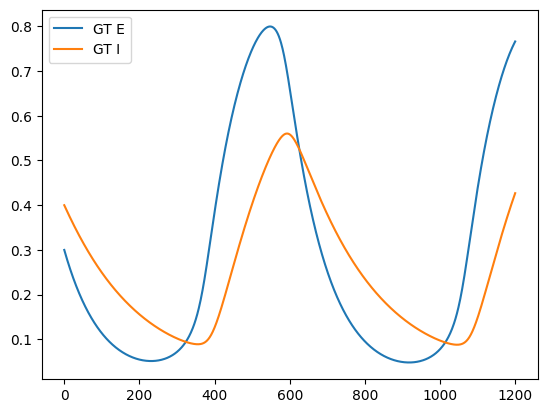

Iteration 0
Parameter p(a)_r0 [n = 1, mu=tensor([[0.]]), cov=tensor([[25.]])
Parameter p(b)_r0 [n = 1, mu=tensor([[0.]]), cov=tensor([[25.]])
Parameter p(c)_r0 [n = 1, mu=tensor([[0.]]), cov=tensor([[25.]])
Parameter p(d)_r0 [n = 1, mu=tensor([[0.]]), cov=tensor([[25.]])
Parameter p(P)_r0 [n = 1, mu=tensor([[0.]]), cov=tensor([[25.]])
Parameter p(Q)_r0 [n = 1, mu=tensor([[0.]]), cov=tensor([[25.]])
Iteration 1
Parameter p(a)_r0 [n = 1, mu=tensor([[0.0002]]), cov=tensor([[2.1957e-05]])
Parameter p(b)_r0 [n = 1, mu=tensor([[0.0004]]), cov=tensor([[3.4824e-07]])
Parameter p(c)_r0 [n = 1, mu=tensor([[3.0774]]), cov=tensor([[0.0017]])
Parameter p(d)_r0 [n = 1, mu=tensor([[4.5012]]), cov=tensor([[0.0017]])
Parameter p(P)_r0 [n = 1, mu=tensor([[3.0042]]), cov=tensor([[0.0017]])
Parameter p(Q)_r0 [n = 1, mu=tensor([[3.3161]]), cov=tensor([[0.0016]])
Iteration 2
Parameter p(a)_r0 [n = 1, mu=tensor([[0.0037]]), cov=tensor([[1.2087e-05]])
Parameter p(b)_r0 [n = 1, mu=tensor([[0.0013]]), cov=tenso

In [7]:
from fg.variables import Variable, Parameter
from fg.factors import DynamicsFactor, ObservationFactor, PriorFactor, AggregationFactor
from fg.simulation_config import simulate_wc
from fg.graph import Graph
from fg.gaussian import Gaussian
import torch
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt

if __name__ == "__main__":
    sigma_obs = 1e-3
    sigma_dynamics = 1e-3
    sigma_prior = 5e0
    iters = 100
    T = 12
    nr = 1
    dt = 0.01

    C = torch.empty((nr, nr)).normal_(0.2, 0.1)
    C.fill_diagonal_(0.)

    config = {
        'T': T,
        'dt': dt,
        'nr': nr,
        'C': C,
        'a': torch.empty((nr,)).normal_(3., 1.),
        'b': torch.empty((nr,)).normal_(5., 1.),
        'c': torch.empty((nr,)).normal_(4., 1.),
        'd': torch.empty((nr,)).normal_(3., 1.),
        'P': torch.empty((nr,)).normal_(1., 0.1),
        'Q': torch.empty((nr,)).normal_(1., 0.1),
    }

    E, I = simulate_wc(config)
    time = torch.arange(0, T + dt, dt)
    plt.plot(E, label='GT E')
    plt.plot(I, label='GT I')
    plt.legend()
    plt.show()
    # fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    factor_graph = Graph()

    param_list = ['a', 'b', 'c', 'd', 'P', 'Q']
    
    # Create the E-I oscillators and add priors to those oscillators
    for t in range(len(time)):
        for r in range(nr):
            factor_graph.var_nodes[f'osc_t{t}_r{r}'] = Variable(
                id       = f'osc_t{t}_r{r}',
                belief   = Gaussian(torch.tensor([[0.1, 0.1]]).T, torch.tensor([[0.2, 0.], [0., 0.2]])),
                graph    = factor_graph, 
                num_vars = 2,
                connected_factors = [f'agg_t{t}_r{r_id}' for r_id in range(nr) if r_id != r] if t+1 < len(time) else []
            )
            
            factor_graph.factor_nodes[f'obs_t{t}_r{r}'] = ObservationFactor(
                factor_id = f'obs_t{t}_r{r}', 
                var_id    = f'osc_t{t}_r{r}',
                z         = torch.tensor([[E[t, r], I[t, r]]]).T.float(),
                lmbda_in  = torch.tensor([[sigma_obs ** -2, 0.], [0., sigma_obs ** -2]]),
                graph     = factor_graph
            )

    # Add parameters to each region
    for p in param_list:
        for r in range(nr):
            p_id = f'p({p})_r{r}'

            factor_graph.param_ids.append(p_id)      
            factor_graph.var_nodes[p_id] = Parameter(
                id     = p_id, 
                belief = Gaussian(torch.tensor([[0.]]), torch.tensor([[sigma_prior ** 2.]])),
                graph  = factor_graph,
                connected_factors = [(f'osc_t{t}_r{r}', f'osc_t{t+1}_r{r}') for t in range(len(time)-1)]
            ) 

            # Add priors to those parameters
            factor_graph.factor_nodes[f'p_prior_p{p}_r{r}'] = PriorFactor(
                factor_id = f'p_prior_p{p}_r{r}',
                var_id = p_id,
                z = torch.tensor([[3.]]).T, 
                lmbda_in = torch.diag(torch.tensor([sigma_prior ** -2])),
                graph = factor_graph
            )


    # Add the dynamics factors between timesteps in every region
    for r in range(nr):
        for t in range(len(time)):
            if t+1 < len(time):
                dyn_id = (f'osc_t{t}_r{r}', f'osc_t{t+1}_r{r}')
                factor_graph.factor_nodes[dyn_id] = DynamicsFactor(
                    Vt_id  = f'osc_t{t}_r{r}',
                    Vtp_id = f'osc_t{t+1}_r{r}',
                    Sigma_id = f'in_t{t}_r{r}', 
                    lmbda_in = torch.tensor([[sigma_dynamics ** -2]]),
                    factor_id = dyn_id, 
                    graph = factor_graph,
                    connected_params = [f'p({p})_r{r}' for p in param_list]
                )

                # For the two nodes that we have just connected, add this dyn. factor
                # as an adjacent connected factor
                factor_graph.var_nodes[f'osc_t{t}_r{r}'].connected_factors.append(dyn_id)
                factor_graph.var_nodes[f'osc_t{t+1}_r{r}'].connected_factors.append(dyn_id)


    # Create the input variables and the aggregation factor for inter-region connections
    for t in range(len(time)):
        for r in range(nr):
            if t+1 < len(time):
                # Create input variables that connect to each dynamic factor
                factor_graph.var_nodes[f'in_t{t}_r{r}'] = Variable(
                    id = f'in_t{t}_r{r}',
                    belief = Gaussian(torch.tensor([[0.]]), torch.tensor([[0.2]])), 
                    graph = factor_graph,

                    # Connect this variable to its aggregation factor and its corresponding 
                    connected_factors = [f'agg_t{t}_r{r}', (f'osc_t{t}_r{r}', f'osc_t{t+1}_r{r}')]
                )

                # Add priors to the input variables for stability
                factor_graph.factor_nodes[f'p_in_t{t}_r{r}'] = PriorFactor(
                    factor_id = f'p_in_t{t}_r{r}',
                    var_id = f'in_t{t}_r{r}',
                    z = torch.tensor([[0., 0.]]).T, 
                    lmbda_in =  torch.tensor([[0.1 ** -2, 0.], [0., 0.1 ** -2]]),
                    graph = factor_graph
                )

                # Add nr-ary aggregation factor between our nr-1 regions and \Sigma var.
                factor_graph.factor_nodes[f'agg_t{t}_r{r}'] = AggregationFactor(
                    factor_id = f'agg_t{t}_r{r}',
                    region_id = r,
                    input_id = f'in_t{t}_r{r}',
                    C = C,
                    lmbda_in = torch.tensor([[1e-3 ** -2]]),
                    graph = factor_graph,
                    connected_regions = [f'osc_t{t}_r{i}' for i in range(nr) if i != r]
                )

    def process_oscillator(t, r, factor_graph):
        curr = factor_graph.var_nodes[f'osc_t{t}_r{r}']
        curr.compute_and_send_messages()

    def process_aggregation_and_input(t, r, factor_graph):
        factor_graph.factor_nodes[f'agg_t{t}_r{r}'].compute_and_send_messages()  
        factor_graph.var_nodes[f'in_t{t}_r{r}'].compute_and_send_messages()

    def process_dynamics(t, r, factor_graph):
        factor_graph.factor_nodes[(f'osc_t{t}_r{r}', f'osc_t{t+1}_r{r}')].compute_and_send_messages()
    
    def parallel_loop(func, nr, t, factor_graph):
        with ThreadPoolExecutor(max_workers=8) as executor:
            futures = [executor.submit(func, t, r, factor_graph) for r in range(nr)]
            for future in as_completed(futures):
                future.result()  # This will raise an exception if one occurred during the execution
    
    for iter in range(iters):
        print(f'Iteration {iter}')
        for r in range(nr):
            for a in param_list:
                print(factor_graph.var_nodes[f'p({a})_r{r}'])

            if factor_graph.var_nodes[f'p({p})_r{r}'].belief.eta.isnan().any(): 
                exit(0)
        
        if iter == 0:
            factor_graph.update_all_observational_factors()
            for i in factor_graph.var_nodes:
                curr = factor_graph.var_nodes[i]
                curr.compute_and_send_messages()
            
            factor_graph.prune() 

        # Right Pass
        for t in range(len(time)-1):
            # Parallelize oscillator processing
            parallel_loop(process_oscillator, nr, t, factor_graph)

            # Parallelize aggregation and input processing
            parallel_loop(process_aggregation_and_input, nr, t, factor_graph)

            if t+1 < len(time):
                # Parallelize dynamics processing
                parallel_loop(process_dynamics, nr, t, factor_graph)
        
        factor_graph.update_params() 

        # Left Pass
        for t in range(len(time)-2, 0, -1):
            # Parallelize oscillator processing
            parallel_loop(process_oscillator, nr, t, factor_graph)

            # Parallelize aggregation and input processing
            parallel_loop(process_aggregation_and_input, nr, t, factor_graph)

            if t-1 > 0:
                # Parallelize dynamics processing
                parallel_loop(process_dynamics, nr, t-1, factor_graph)
        
        factor_graph.update_params()